In [1]:


import pandas as pd
import numpy as np
np.random.seed(42)

 

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

from IPython.core.pylabtools import figsize


from scipy.stats import percentileofscore
from scipy import stats
from sklearn.linear_model import LinearRegression



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error


import scipy


# Analyse exploratoire.

La première étape pour résoudre un problème de science des donnée est l'analyse exploratoire des données (EDA). Il s'agit d'un processus ouvert où nous recherchons des anomalies, des tendances ou des modèles intéressants et des corrélations dans un ensemble de données. Celles-ci peuvent être intéressantes en elles-mêmes et elles peuvent éclairer notre modélisation. En gros, nous utilisons l'analyse exploratoire pour découvrir ce que nos données peuvent nous dire !
Tout d'abord, regardons un instantané des données:

In [113]:
data = pd.read_csv('insurance.csv')

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [62]:
# matrice de données
X

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


In [63]:
#Target
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [5]:
data.shape

(1338, 7)



Il y a un total de 1338 observations avec 7 variables. Chaque ligne correspond à un patient, chaque colonne contenant une caractéristique différente. La colonne des frais "charges" est notre variable cible, ce qui en fait une tâche d'apprentissage machine de régression supervisée. Il est supervisé car nous avons un ensemble de données d'entraînement avec des cibles connues et, pendant l'entraînement, nous voulons que notre modèle apprenne à prédire les charges à partir des autres variables. Nous traiterons la variable des frais medicaux comme continues, ce qui en fait un problème de régression (techniquement, les charges ne prennent que des valeurs entières, il s'agit donc d'une variable nominale).
Notre principale variable d'intérêt: "charges", alors examinons la distribution pour vérifier l'asymétrie :

Text(0.5, 1.0, 'Distribution of charges')

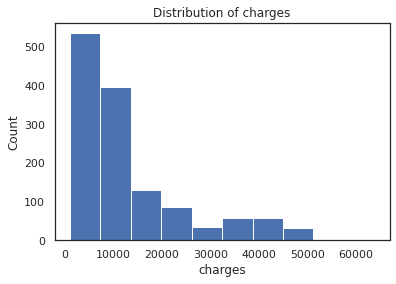

In [50]:
# Histogramme de la variable: charges
plt.hist(data['charges'])
plt.xlabel('charges')
plt.ylabel('Count')
plt.title('Distribution of charges')

Le graphe montre qu'il y'a une asymétrie positive, nous résolvons ce problème avec la normalisation. 

Text(0.5, 1.0, 'Distribution of charges')

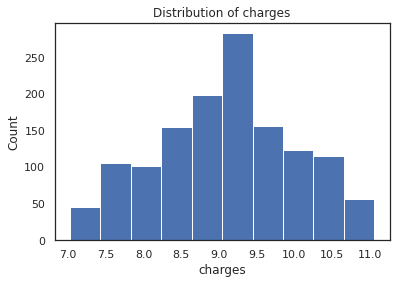

In [52]:
# Histogramme : log(charges)
plt.hist(np.log(data['charges']))
plt.xlabel('charges')
plt.ylabel('Count')
plt.title('Distribution of charges')


In [ ]:
data.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

$\color{BLUE}{\text{distribution des charges en fonction de la région}}$


Text(0.5, 1.0, 'Density Plot of Final charges by region')

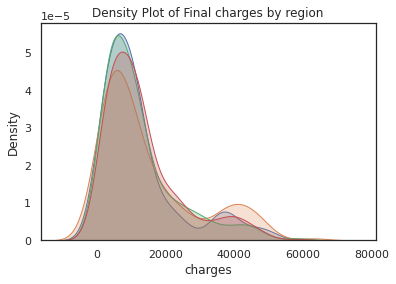

In [53]:
import seaborn as sns # pour faire des graphes.
# un plot pour chaque location. 
sns.kdeplot(data.loc[data['region'] == 'southwest', 'charges'], 
            label = 'southwest', shade = True)
sns.kdeplot(data.loc[data['region'] == 'southeast', 'charges'], 
            label = 'southeast', shade = True)
sns.kdeplot(data.loc[data['region'] == 'northwest', 'charges'], 
            label = 'northwest', shade = True)
sns.kdeplot(data.loc[data['region'] == 'northeast', 'charges'], 
            label = 'northeast', shade = True)
# Add labeling
plt.xlabel('charges')
plt.ylabel('Density')
plt.title('Density Plot of Final charges by region')

$\color{BLUE}{\text{distribution des charges en fonction du sexe}}$



Text(0.5, 1.0, 'Density Plot of Final charges by sex')

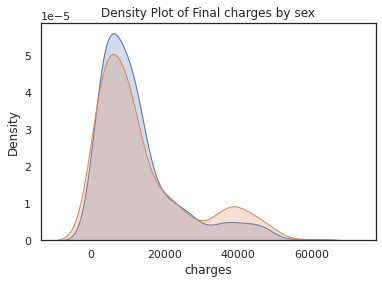

In [54]:
import seaborn as sns
# Make one plot for each different location
sns.kdeplot(data.loc[data['sex'] == 'female', 'charges'], 
            label = 'southwest', shade = True)
sns.kdeplot(data.loc[data['sex'] == 'male', 'charges'], 
            label = 'southeast', shade = True)

plt.xlabel('charges')
plt.ylabel('Density')
plt.title('Density Plot of Final charges by sex')

la localisation (variable: region) et le sexe de l'individu ne semblent pas avoir un impact substantiel sur les charges médicaux. 

$\color{BLUE}{\text{selection des variables}}$



Comme nous l'avons vu sur les graphiques, nous ne nous attendons pas à ce que chaque variable soit liée à la variable cible: charges, nous devons donc effectuer une sélection de variables (réduction de dimensionnalité) pour choisir uniquement les variables « pertinentes ». Cela dépend du problème, mais comme nous allons faire de la modélisation linéaire dans ce projet, nous pouvons utiliser le coefficient de corrélation pour déterminer les variables les plus utiles pour prédire une note. 
Pour sélectionner un nombre limité de variables, on peut trouver celles qui ont la plus grande corrélation (soit négative soit positive) avec la variables "charges".

In [68]:
data["log_bmi"]=np.log(data.bmi)

In [69]:
# Find correlations and sort
data.corr()['charges'].sort_values()

children    0.067998
bmi         0.198341
log_bmi     0.199266
age         0.299008
charges     1.000000
Name: charges, dtype: float64

Les corrélations ne peuvent être calculées qu'entre des variables numériques, donc pour trouver la relation entre les variables catégorielles et la variable "charges", nous devons encoder la variable catégorielle puis calculer le coefficient de corrélation. 

In [56]:
# selection des variables catégorielles
data_categorielle = data.select_dtypes('object')
# recodage dans un nouveau jeu de données
dummy_data = pd.get_dummies(data_categorielle)
# ajoutons notre variable cible à ce jeu.
dummy_data['charges'] = data['charges']
# Calcul des corrélation
dummy_data.corr()['charges'].sort_values()

smoker_no          -0.787251
sex_female         -0.057292
region_southwest   -0.043210
region_northwest   -0.039905
region_northeast    0.006349
sex_male            0.057292
region_southeast    0.073982
smoker_yes          0.787251
charges             1.000000
Name: charges, dtype: float64

la variable "smoker_yes" est fortement corrélée (\rho=0.787251) avec la variable "charges", tandis que la variable "smoker_no" est fortement corrélée (\rho=-0.787251) avec la dite variable cible.

In [ ]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

Nous voyons à nouveau des relations qui ont un sens intuitivement : smoker_no représente que le patient ne paie pas de frais plus élevés et est négativement corrélé (fortement) avec les frais, atandis que smoker_yes indique que le patient paie des frais plus élevés et montre une corrélation positive.




Divisons les données en un ensemble d'apprentissage et de test à l'aide d'une fonction Scikit-learn. 

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state=42)


$\color{BLUE}{\text{ Visualisation de la matrice de corrélation:}}$

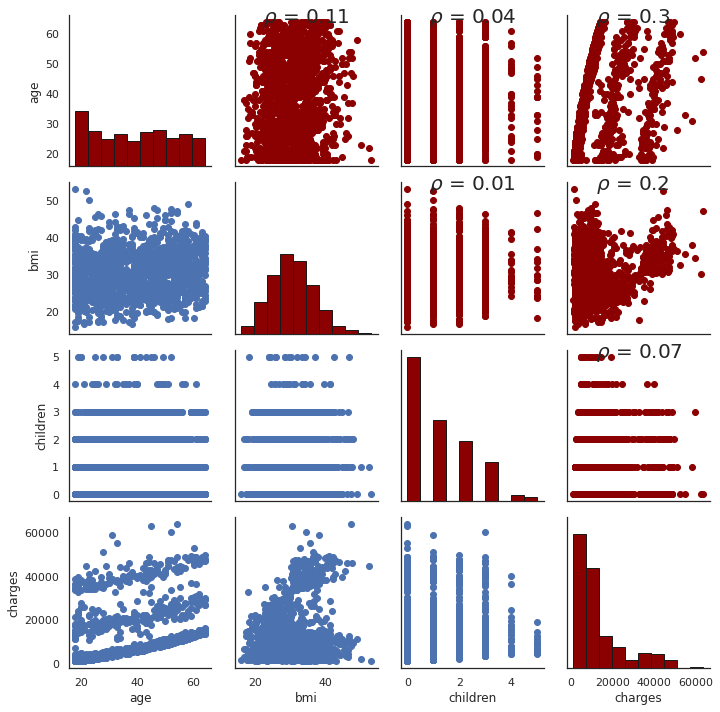

In [65]:

def corr(x, y, **kwargs):
    
    # Calcul du coefficient
    coef = np.corrcoef(x, y)[0][1]
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
    

grid = sns.PairGrid(data=data,palette = ['red'])

# Map the plots to the locations
grid = grid.map_upper(plt.scatter, color = 'darkred')
grid = grid.map_upper(corr)
grid = grid.map_lower(plt.scatter)
grid = grid.map_diag(plt.hist, bins = 10, edgecolor =  'k', color = 'darkred');

In [67]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


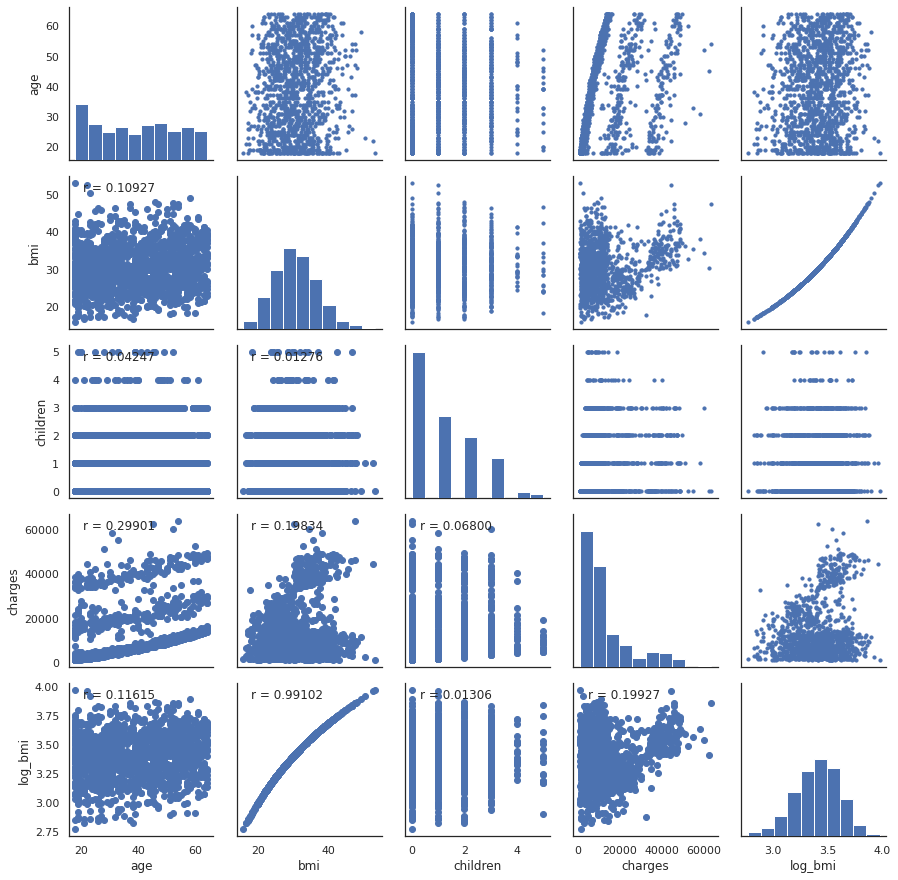

In [70]:


import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")


def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.5f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(data, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(plt.hist, )
g.map_lower(plt.scatter,)
g.map_lower(corrfunc)

In [ ]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


$\color{BLUE}{\text{ Selection des variables les plus corrélées.}}$

In [99]:
#Cette fonction nous permet de:
#*** controler le nombre de variables corrélées qu'on voudra retenir avec la variable cible.
#*** faire un nouveau jeu de données visant la modèlisation.
def format_data(data):
    labels = data['charges']      
    # recodage
    data = pd.get_dummies(data)  
    # correlations avec la variable charges par ordre décroissant
    plus_correlees = data.corr().abs()['charges'].sort_values(ascending=False)       
    plus_correlees = plus_correlees[:4]    
    data = data.loc[:, plus_correlees.index]      
    X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                        test_size = 0.25,
                                                        random_state=42)    
    return X_train, X_test, y_train, y_test

In [75]:
X_train, X_test, y_train, y_test = format_data(data)
X_train.head()

,charges,smoker_no,smoker_yes,age
693,2352.96845,1,0,24
1297,4340.44090,1,0,28
634,9391.34600,1,0,51
1022,42211.13820,0,1,47
178,8823.27900,1,0,46


In [73]:
print(X_train.shape)
print(X_test.shape)

(1003, 4)
(335, 4)


$\color{BLUE}{\text{ Régression linéaire classique.}}$



1.  Modèle.




In [81]:
lr = LinearRegression()
lr.fit(X_train.drop(columns='charges'), y_train)

ols_formula = 'charges = %0.2f +' % lr.intercept_
for i, col in enumerate(X_train.columns[1:]):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[i], col)
    
' '.join(ols_formula.split(' ')[:-1])

'charges = 9342.28 + -11840.87 * smoker_no + 11840.87 * smoker_yes + 277.74 * age'

In [76]:

def evaluate(X_train, X_test, y_train, y_test):

    model_name_list = ['Linear Regression']

    model1 = LinearRegression()

    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    for i, model in enumerate([model1]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [77]:
results = evaluate(X_train, X_test, y_train, y_test)


In [78]:
results

,mae,rmse
Linear Regression,3.67463e-12,5.08207e-12
Baseline,8509.96,12867.2


$\color{BLUE}{\text{Régression linéaire dans le paradigme bayésien.}}$

In [105]:
#formula=modèle
modele= 'charges ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
modele

'charges ~ smoker_no + smoker_yes + age'

In [84]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + tau * N
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [85]:
def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [86]:
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

Text(0, 0.5, 'y')

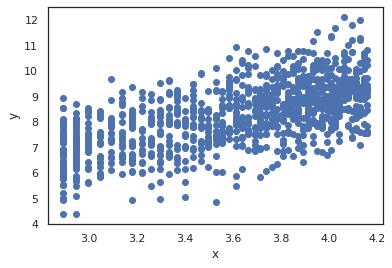

In [87]:
beta_0_true = 1
beta_1_true = 2
tau_true = 1


x = np.log(X_train.age)   ###### Log(age)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

synth_plot = plt.plot(x, y, "o")
plt.xlabel("x")
plt.ylabel("y")


In [24]:
X_train

,charges,smoker_no,smoker_yes,age
693,2352.96845,1,0,24
1297,4340.44090,1,0,28
634,9391.34600,1,0,51
1022,42211.13820,0,1,47
178,8823.27900,1,0,46
...,...,...,...,...
1095,4561.18850,1,0,18
1130,8582.30230,1,0,39
1294,11931.12525,1,0,58
860,46113.51100,0,1,37


In [93]:
## Initialisation
init = {"beta_0": 4,
        "beta_1": 1,
        "tau": 2}

##  hyper parameteres
hypers = {"mu_0": 0,
         "tau_0": 1,
         "mu_1": 0,
         "tau_1": 1,
         "alpha": 2,
         "beta": 1}

In [94]:
#tau=1/sigma^2   paramétre de précision
def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3))
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace

In [95]:

y=np.log(y_train)
x=np.log(X_train.age)
iters=2000
trace = gibbs(y, x, iters, init, hypers)

Text(0, 0.5, 'Parameter value')

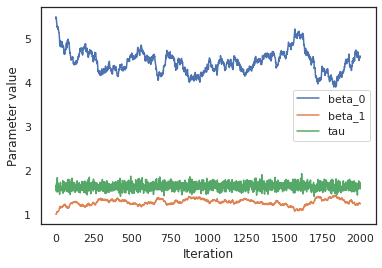

In [96]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

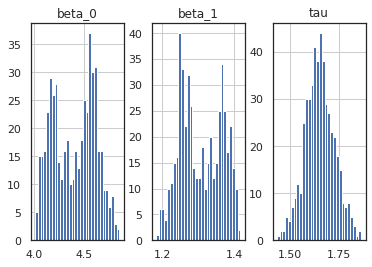

In [97]:
trace_burnt = trace[500:999]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))

In [44]:
print(trace_burnt.median())
print(trace_burnt.std())

beta_0    4.538285
beta_1    1.266330
tau       1.645259
dtype: float64
beta_0    0.292263
beta_1    0.080536
tau       0.072338
dtype: float64


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Text(0, 0.5, 'Parameter value')

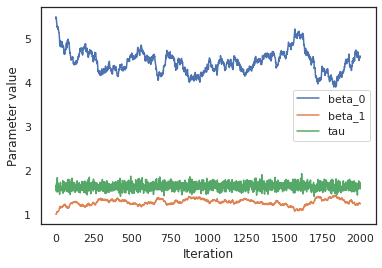

In [98]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Valeur du parametre")

#  Modele avec PyMC3 


In [107]:
X_train=X_train.drop(columns='smoker_yes')

In [114]:
import pymc3 as pm
modele= 'charges ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
modele
with pm.Model() as normal_model:
    
    # les priors du paramètres du modèles suivent la loi de studenty
    family = pm.glm.families.StudentT()
    
   
    pm.GLM.from_formula(modele, data = X_train, family=family)
    

    normal_trace = pm.sample()

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  from ipykernel import kernelapp as app
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, age, smoker_no, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.


In [115]:
def plot_trace(trace):
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),)
    
    matplotlib.rcParams['font.size'] = 16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  after removing the cwd from sys.path.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


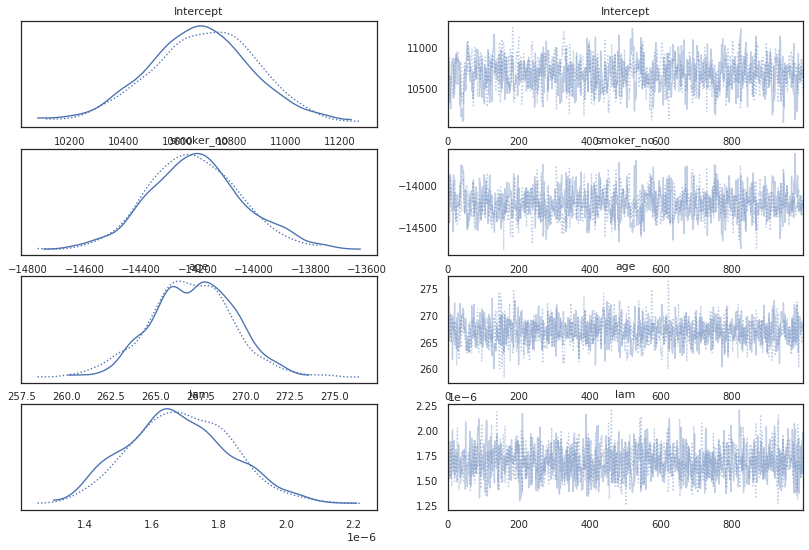

In [116]:
plot_trace(normal_trace);


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f765f2d4650>,
      dtype=object)

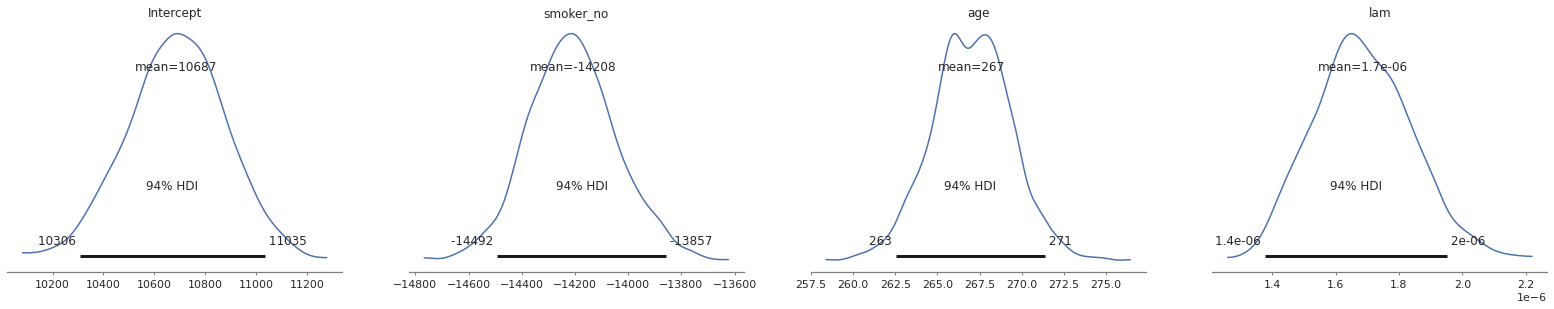

In [117]:
pm.plot_posterior(normal_trace)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


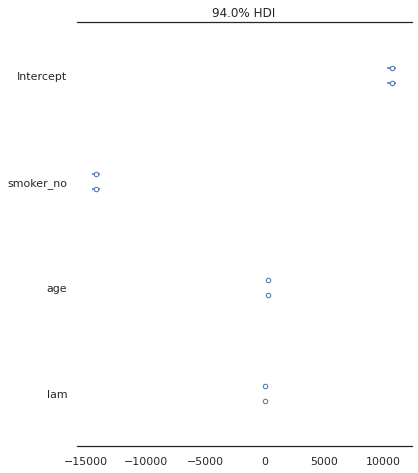

In [118]:
pm.forestplot(normal_trace);


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


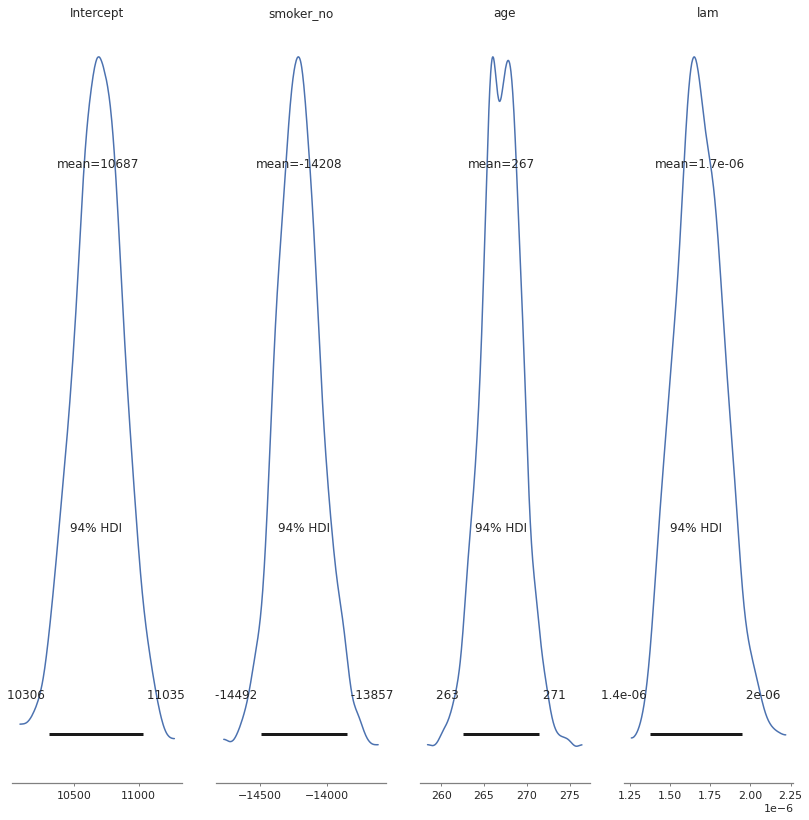

In [120]:
pm.plot_posterior(normal_trace, figsize = (14, 14));


In [124]:
pm.summary(normal_trace)


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,10686.830,194.635,10306.171,11034.879,7.234,5.118,726.0,706.0,1.00
smoker_no,-14207.974,166.059,-14491.624,-13856.854,5.718,4.044,843.0,980.0,1.01
age,267.041,2.367,262.533,271.369,0.074,0.052,1030.0,912.0,1.00
lam,0.000,0.000,0.000,0.000,0.000,0.000,1419.0,1180.0,1.00
